In [10]:
import os
import cv2 
import numpy as np
import pandas as pd
import tensorflow as tf
import easyocr
import matplotlib.pyplot as plt
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# os module provides various functions to interact with the file system, manage directories, and perform other operating system-related tasks.
# cv2  computer vision tasks. It provides various functions for image and video processing.
# numpy scientific computing , large multiD. arrays and matrixes
# pandas powerful and easy-to-use data analysis and manipulation library in Python
# TensorFlow is an open-source machine learning framework , creating a basic neural network
# easyocr optical character recognisation
# matplotlib creating plots, histograms, power spectra, bar charts, error charts, scatterplots

# glob is a module in Python that provides a function by the same name for searching for files that match a specified pattern.
 # It is commonly used to retrieve a list of file paths that match a specified pattern.
# io is a submodule of the skimage (scikit-image) module, which is a collection of algorithms for image processing.
 # It provides various functions for reading, saving, and displaying images.
 # Functions in the io submodule can handle various image formats, making it easy to work with images in different formats within the scikit-image ecosystem.
# copy is a function provided by the shutil (shell utilities) module in Python.
 #  It is used to copy files or directories from one location to another.
 #  The copy function can be used to create a duplicate of a file or directory, and it preserves the file metadata while copying.

In [11]:
import os

# Define the directory path
directory = 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images'

# List all the files in the directory
files = os.listdir(directory)


# Filter files based on your desired pattern
filtered_files = [file for file in files if file.endswith('.xml')]
path=[]
# Print the filtered files
print("\nFiltered files:")
for file in filtered_files:
    f= os.path.join(directory, file)
    path.append(f)
 
# all .xml files are stored in path


Filtered files:


In [12]:
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[]) 
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    # The code snippet essentially reads XML files containing bounding box information for object detection tasks,
    #  extracts the coordinates of the bounding boxes, 
    # and stores this information in a dictionary for further processing or analysis.

In [13]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()
# converts the dictionary labels_dict into a pandas DataFrame,
# saves the DataFrame as a CSV file, and displays the first few rows of the DataFrame.

,filepath,xmin,xmax,ymin,ymax
0,D:\automatic-number-plate-recognition-python-y...,140,339,210,260
1,D:\automatic-number-plate-recognition-python-y...,184,292,572,648
2,D:\automatic-number-plate-recognition-python-y...,327,399,202,227
3,D:\automatic-number-plate-recognition-python-y...,185,374,290,339
4,D:\automatic-number-plate-recognition-python-y...,335,453,313,347


In [14]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join(directory,filename_image)
    return filepath_image
getFilename(filename)

'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg'

In [15]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images\\00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle.jpg',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images\\018b52e6-e9a1-42c2-8ce7-0617e8c8e021___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_sbtb02_auto1.JPG',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images\\03273806-bb1e-48da-8c8b-a0133a90197a___2014-Skoda-Yeti-Test-Drive.jpg.jpeg',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images\\0369b20e-b432-4409-90f9-2420877aa386___8151536c79159a1557421da5f27f9f0e.jpg.jpeg',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\google_images\\07064c2c-2aa3-4419-91a4-92916de8e54c___mahindra-scorpio-old-car-500x500.j

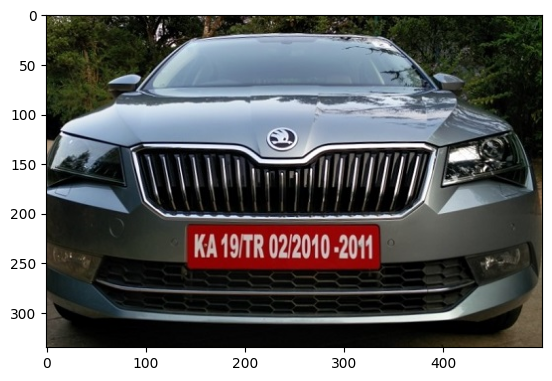

In [16]:
file_path = image_path[0] #path of our image N2.jpeg
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
plt.imshow(img)


In [17]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization intensity
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [18]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

plt.imshow(X[4])

In [19]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((352, 224, 224, 3), (88, 224, 224, 3), (352, 4), (88, 4))

In [20]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# --------------------- model created using inceptionresnet architecture 
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel) 
#  non linearity 


# ---------- model

model = Model(inputs=inception_resnet.input,outputs=headmodel)

# The Model class acts as an interface for creating, training, and using deep learning models, 
# allowing for seamless integration of different types of layers and custom architectures while
#  providing a consistent and user-friendly interface for building complex neural networks.

In [21]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
# loss='mse': The mean squared error (MSE) loss function is used for training the model. 
# Adam is an adaptive learning rate optimization algorithm commonly used for training deep learning models. 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            


                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 32)         9216      ['activation[0][0]']          
                                                                                                  
 batch_nor

In [22]:
model.load_weights('./object_detection1.h5')

In [941]:

history = model.fit(x=x_train,y=y_train,batch_size=8,epochs=10,
                    validation_data=(x_test,y_test))
# x=x_train: The input training data.
# y=y_train: The target training data or labels.
# batch_size=8: The number of samples per gradient update. number of samples that will be propagated through the network before the model's internal parameters are updated.
# epochs=10: The number of epochs or iterations over the entire training dataset.
# validation_data=(x_test, y_test): Data on which to evaluate the loss and any model metrics at the end of each epoch.

Epoch 1/10
44/44 [==============================] - 875s 19s/step - loss: 0.0027 - val_loss: 0.0040
Epoch 2/10
44/44 [==============================] - 1237s 29s/step - loss: 0.0012 - val_loss: 0.0033
Epoch 3/10
44/44 [==============================] - 3369s 78s/step - loss: 7.4822e-04 - val_loss: 0.0025
Epoch 4/10
44/44 [==============================] - 10895s 253s/step - loss: 6.0460e-04 - val_loss: 0.0021
Epoch 5/10
44/44 [==============================] - 669s 15s/step - loss: 5.0926e-04 - val_loss: 0.0023
Epoch 6/10
44/44 [==============================] - 583s 13s/step - loss: 4.5073e-04 - val_loss: 0.0022
Epoch 7/10
44/44 [==============================] - 566s 13s/step - loss: 3.5726e-04 - val_loss: 0.0019
Epoch 8/10
44/44 [==============================] - 581s 13s/step - loss: 3.8998e-04 - val_loss: 0.0019
Epoch 9/10
44/44 [==============================] - 595s 14s/step - loss: 3.3657e-04 - val_loss: 0.0019
Epoch 10/10
44/44 [==============================] - 12549s 292s/st

In [23]:
model.save('./object_detection1.h5')

c:\Users\pulki\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model = tf.keras.models.load_model('./object_detection1.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [25]:
i=1
cam="1"
path = f"D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\TEST\\TEST1.jpeg"
image = load_img(path)
image = np.array(image,dtype=np.uint8) 
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0 


h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)
print(cam)


Height of the image = 510
Width of the image = 827
1


In [26]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [27]:
coords = model.predict(test_arr)
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords = coords.astype(np.int32)


1/1 [==============================] - 6s 6s/step


In [28]:
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(324, 313) (563, 362)


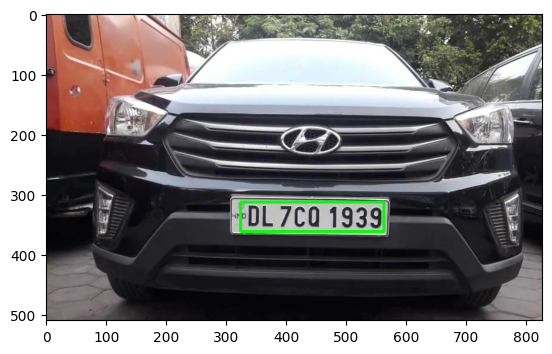

In [29]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
plt.imshow(image)

In [30]:

def object_detection(path):
    
    image = load_img(path) 
    image = np.array(image,dtype=np.uint8) 
    image1 = load_img(path,target_size=(224,224))
    
    image_arr_224 = img_to_array(image1)/255.0 
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    coords = model.predict(test_arr)
    
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)



1/1 [==============================] - 0s 252ms/step
(324, 313) (563, 362)


In [31]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


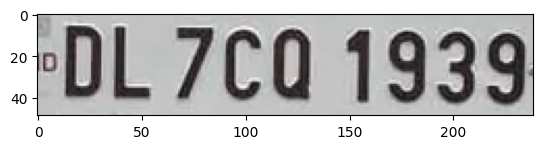

In [51]:
image = roi

reader = easyocr.Reader(['en'])  

result = reader.readtext(image, allowlist = ' 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
out=[]
for detection in result:
    out.append(detection[1])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [53]:
text = ' '.join(out)
print(text)

DL 7C0 1939


In [38]:
# import pytesseract
# import re

# # text = pytesseract.image_to_string(image, config=custom_config)

# # print("Extracted Text: ", text)


# myconfig = r"--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789QWERTYUIOPASDFGHJKLZXCVBNM"

# # Extract text from the image
# text = pytesseract.image_to_string(image, config=myconfig)

# # Define a regular expression pattern to match the desired format
# pattern = (r"^(IND)\s([A-Z]{2}\d{2}[A-Z]{2}\d{4})$")

# # Search for the pattern in the extracted text
# match = re.search(pattern, text)

# if match:
#     extracted_string = match.group(1)
#     print("Extracted String:", extracted_string)
# else:
#     print("Pattern not found in the text.")
#     # If the pattern is not found, replace 'Z' with '2' and 'I' with '1' in the entire text
#     text = re.sub(r'Z', '2', text)
#     text = re.sub(r'I', '1', text)
#     print("Modified Text:", text)

In [49]:
from datetime import datetime

now = datetime.now()
print('The date and time(greenwich standard time) of entry of vehicle is: ', now)

# Convert now to string
now_string = now.strftime('%Y-%m-%d %H:%M:%S')
print('Now as string:', now_string)


The date and time(greenwich standard time) of entry of vehicle is:  2023-11-03 18:06:15.469873
Now as string: 2023-11-03 18:06:15


In [50]:
f = open("myfile.txt" , "w")
f.write(text +"\n")
f.write(cam + "\n")
f.write(now_string + "\n")
f = open("myfile.txt" , "r")
print(f.read())

DL 7C0 1939
1
2023-11-03 18:06:15

